## Downlading PanNuke Dataset

In [1]:
! wget https://warwick.ac.uk/fac/cross_fac/tia/data/pannuke/fold_1.zip
! wget https://warwick.ac.uk/fac/cross_fac/tia/data/pannuke/fold_2.zip
! wget https://warwick.ac.uk/fac/cross_fac/tia/data/pannuke/fold_3.zip

--2021-08-16 12:26:17--  https://warwick.ac.uk/fac/cross_fac/tia/data/pannuke/fold_1.zip
Resolving warwick.ac.uk (warwick.ac.uk)... 137.205.28.41
Connecting to warwick.ac.uk (warwick.ac.uk)|137.205.28.41|:443... connected.
HTTP request sent, awaiting response... 200 
Length: 700275281 (668M) [application/zip]
Saving to: ‘fold_1.zip’

fold_1.zip          100%[===================>] 667.83M  19.9MB/s    in 35s     

2021-08-16 12:26:52 (18.8 MB/s) - ‘fold_1.zip’ saved [700275281/700275281]

--2021-08-16 12:26:52--  https://warwick.ac.uk/fac/cross_fac/tia/data/pannuke/fold_2.zip
Resolving warwick.ac.uk (warwick.ac.uk)... 137.205.28.41
Connecting to warwick.ac.uk (warwick.ac.uk)|137.205.28.41|:443... connected.
HTTP request sent, awaiting response... 200 
Length: 658842552 (628M) [application/zip]
Saving to: ‘fold_2.zip’

fold_2.zip          100%[===================>] 628.32M  19.2MB/s    in 33s     

2021-08-16 12:27:25 (19.1 MB/s) - ‘fold_2.zip’ saved [658842552/658842552]

--2021-08-16 1

In [2]:
!unzip fold_1.zip
!unzip fold_2.zip
!unzip fold_3.zip

Archive:  fold_1.zip
   creating: Fold 1/
  inflating: Fold 1/README.md        
   creating: Fold 1/masks/
  inflating: Fold 1/masks/by-nc-sa.md  
  inflating: Fold 1/masks/README.md  
   creating: Fold 1/masks/fold1/
  inflating: Fold 1/masks/fold1/masks.npy  
   creating: Fold 1/images/
   creating: Fold 1/images/fold1/
  inflating: Fold 1/images/fold1/types.npy  
  inflating: Fold 1/images/fold1/images.npy  
Archive:  fold_2.zip
   creating: Fold 2/
  inflating: Fold 2/README.md        
   creating: Fold 2/images/
   creating: Fold 2/images/fold2/
  inflating: Fold 2/images/fold2/images.npy  
  inflating: Fold 2/images/fold2/types.npy  
   creating: Fold 2/masks/
  inflating: Fold 2/masks/by-nc-sa.md  
  inflating: Fold 2/masks/README.md  
   creating: Fold 2/masks/fold2/
  inflating: Fold 2/masks/fold2/masks.npy  
Archive:  fold_3.zip
   creating: Fold 3/
  inflating: Fold 3/README.md        
   creating: Fold 3/images/
   creating: Fold 3/images/fold3/
  inflating: Fold 3/images/f

Instead of handling the patch and subpatch level rotation during training, I have generated the train and test data sepratedly just to make the process simpler. However, this can be implemented in other ways. 

In [14]:
import numpy as np
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from skimage.transform import rotate
import os

def counter(M,I,rot):
    Y=[]
    X =[]
    for m in range(M.shape[0]):
        for time in range(len(rot)):
            img =I[m,:,:,:].astype('uint8')
            X.append(rotate(img,rot[time]))
            c,cl,cr,ct,cb=[],[],[],[],[]
            for i in range(M.shape[-1]):
                mask = np.rot90(M[m,:,:,i],time)
                c.append(len(np.unique(mask))-1)
                cl.append(len(np.unique(mask[:,:(mask.shape[1]//2)]))-1)
                cr.append(len(np.unique(mask[:,(mask.shape[1]//2):]))-1)
                ct.append(len(np.unique(mask[:(mask.shape[0]//2),:]))-1)
                cb.append(len(np.unique(mask[(mask.shape[0]//2):,:]))-1)
            Y.append([c,cl,cr,ct,cb])
    return np.array(X),np.array(Y)

def readFold(f=1, focus='Breast',rot=[0]):
    bdir = f'Fold {f}'
    ifile = bdir+f'/images/fold{f}/images.npy'
    tfile = bdir+f'/images/fold{f}/types.npy'
    mfile = bdir+f'/masks/fold{f}/masks.npy'
    T = np.load(tfile)
    #import pdb; pdb.set_trace()
    M = np.load(mfile)
    I = np.load(ifile)
    if focus is not None:
         M = M[T==focus]
         I = I[T==focus]
         print("PanNuke BRCA fold: ",f,"Shape of Mask",M.shape,"Shape of Input Images",I.shape)
         X,Y = counter(M,I,rot)
    else:
        X,Y = counter(M,I,rot)
    return X,Y

def mkdirs(dirs):
    if not os.path.exists(dirs):
        os.makedirs(dirs)

## Generating training data

In [16]:
train_rot = [0,90,180,270]
out_dir = 'BRCA_train/'
for i in range(1,4):
    Xtr,Ytr= readFold(f=i,rot=train_rot)
    mkdirs(out_dir) # Output directory where fold will be saved
    np.savez(out_dir+'fold_'+str(i),X= Xtr,Y=Ytr)
    print(Xtr.shape,Ytr.shape)

PanNuke BRCA fold:  1 Shape of Mask (827, 256, 256, 6) Shape of Input Images (827, 256, 256, 3)
(3308, 256, 256, 3) (3308, 5, 6)
PanNuke BRCA fold:  2 Shape of Mask (749, 256, 256, 6) Shape of Input Images (749, 256, 256, 3)
(2996, 256, 256, 3) (2996, 5, 6)
PanNuke BRCA fold:  3 Shape of Mask (775, 256, 256, 6) Shape of Input Images (775, 256, 256, 3)
(3100, 256, 256, 3) (3100, 5, 6)


## Generating Validation data

In [17]:
val_rot = [0]        
for i in range(1,4):
    Xv,Yv= readFold(f=i,rot=val_rot)
    mkdirs('BRCA_val/')
    np.savez('BRCA_val/fold_'+str(i),X= Xv,Y=Yv)
    print(Xv.shape,Yv.shape)

PanNuke BRCA fold:  1 Shape of Mask (827, 256, 256, 6) Shape of Input Images (827, 256, 256, 3)
(827, 256, 256, 3) (827, 5, 6)
PanNuke BRCA fold:  2 Shape of Mask (749, 256, 256, 6) Shape of Input Images (749, 256, 256, 3)
(749, 256, 256, 3) (749, 5, 6)
PanNuke BRCA fold:  3 Shape of Mask (775, 256, 256, 6) Shape of Input Images (775, 256, 256, 3)
(775, 256, 256, 3) (775, 5, 6)


## Visualizing training patches along with target counts

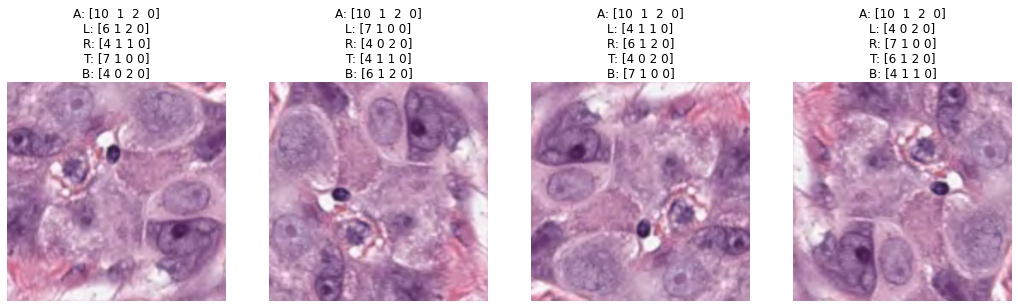

In [47]:
import matplotlib.pyplot as plt
im_idx = [0,1,2,3]
plt.figure(figsize=(18,18))

# the Dataset consist of 6 cell types in the following order we slecting the four types
#[Neoplastic,inflammatory, Connective, Necrotic, Epithelial, Background]
ct_index = [0,1,2,4]

Yftr = Ytr[:,:,[0,1,2,4]]
for idx in range(len(im_idx)):
    plt.subplot(1,4,idx+1)
    plt.imshow(Xtr[idx])
    plt.axis('off')
    plt.title('A: '+ str(Yftr[idx][0])+'\nL: '+str(Yftr[idx][1])+'\nR: '+str(Yftr[idx][2])+'\nT: '+str(Yftr[idx][3]) 
              +'\nB: ' +str(Yftr[idx][4]) )

## Loading Image annotated mask with their counts

In [30]:
def loadMask(f=1, focus='Breast'):
    bdir = f'Fold {f}'
    tfile = bdir+f'/images/fold{f}/types.npy'
    mfile = bdir+f'/masks/fold{f}/masks.npy'
    T = np.load(tfile)
    #import pdb; pdb.set_trace()
    M = np.load(mfile)
    if focus is not None:
         M = M[T==focus]
    return M

Mv = loadMask(f=3)

In [32]:
print(Mv.shape,Xv.shape,Yv.shape)

(775, 256, 256, 6) (775, 256, 256, 3) (775, 5, 6)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


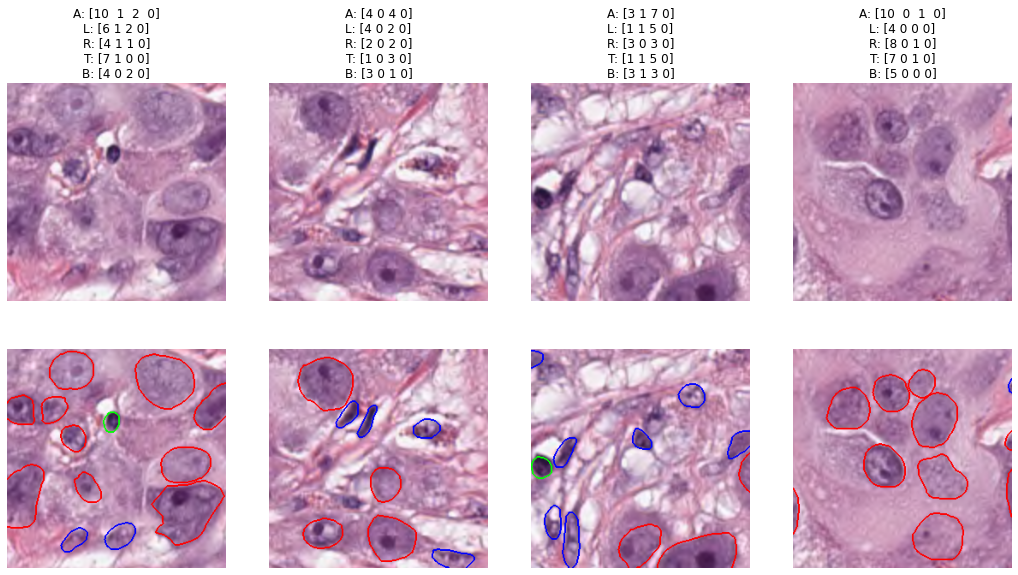

In [48]:
import matplotlib.pyplot as plt
im_idx = [0,1,2,3]
plt.figure(figsize=(18,9))

# the Dataset consist of 6 cell types in the following order we slecting the four types
#[Neoplastic,inflammatory, Connective, Necrotic, Epithelial, Background]
ct_index = [0,1,2,4]

Yfv = Yv[:,:,[0,1,2,4]]
for idx in range(len(im_idx)):
    plt.subplot(2,4,idx+1)
    plt.imshow(Xv[idx])
    plt.axis('off')
    plt.title('A: '+ str(Yfv[idx][0])+'\nL: '+str(Yfv[idx][1])+'\nR: '+str(Yfv[idx][2])+'\nT: '+str(Yfv[idx][3]) 
              +'\nB: ' +str(Yfv[idx][4]) )
from skimage import segmentation   
color_pannuke = {
    #"0" : ["nolabe", [0  ,   0,   0]], 
    "0" : ["neopla", [255,   0,   0]], 
    "1" : ["inflam", [0  , 255,   0]], 
    "2" : ["connec", [0  ,   0, 255]], 
    #"4" : ["necros", [255, 255,   0]], 
    "4" : ["no-neo", [255, 165,   0]] 
}

for idx in range(len(im_idx)):
    plt.subplot(2,4,len(im_idx)+idx+1)
    ct = [0,1,2,4]
    img = Xv[idx]
    for i in  ct:  
        overlay = Mv[idx][:,:,i]
        img = segmentation.mark_boundaries(img,overlay,color=color_pannuke[str(i)][1], mode='thin')
    plt.imshow(img)
    plt.axis('off')